In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sn
import mpld3
import pandas as pd
import numpy as np
import imp
from mpl_toolkits.basemap import Basemap
import mplleaflet
import pymc3 as pm
import scipy.stats as st

sn.set_context('talk')

In [2]:
# Optionally suppress warnings in the final version of the notebook
import warnings
warnings.filterwarnings('ignore')

# ECOREG full analysis (part 2: differences)

This notebook follows on from the work described [here](http://nbviewer.jupyter.org/github/JamesSample/ECOREG/blob/master/ecoreg_full_analysis_1.ipynb), where PCA was used to make the raw dataset more manageable and also to identify some specific hypotheses to test.

In [3]:
# Read basic datasets

# Hydro indicators
in_xls = r'C:\Data\James_Work\Staff\Susi_S\ECOREG\Stats_Input_Data\hydro_indic.xlsx'
hi_df = pd.read_excel(in_xls, sheetname='hydro_indic', index_col=0)

# Site props
in_xls = r'C:\Data\James_Work\Staff\Susi_S\ECOREG\Stats_Input_Data\site_props.xlsx'
site_df = pd.read_excel(in_xls, sheetname='site_props', index_col=0)

# MZB
in_xls = r'C:\Data\James_Work\Staff\Susi_S\ECOREG\Stats_Input_Data\mzb_chem_ecol.xlsx'
mzb_df = pd.read_excel(in_xls, sheetname='mzb_data', index_col=0)

# PB
in_xls = r'C:\Data\James_Work\Staff\Susi_S\ECOREG\Stats_Input_Data\pb_chem_ecol.xlsx'
pb_df = pd.read_excel(in_xls, sheetname='pb_data', index_col=0)

## 5. Tests for differences between groups

My impression so far is that the differences between regulated an unregulated sites in our dataset are small, which means we will struggle to say much about the effects of river regulation on our variables of interest. Nevertheless, the PCA highlighted some metrics for further investigation, which will be explored here. The simplest starting point is to group the metrics for regulated versus unregulated rivers and then test to see whether the differences are statistically significant. 

The standard frequentist approach to testing for differences between two groups is the t-test, but in this notebook I'm going to take a Bayesian interpretation of probability, which I find more flexible and intuitive. My method is broadly that described in [Kruschke (2013)](http://www.indiana.edu/~kruschke/articles/Kruschke2013JEPG.pdf), except I'll be using [PyMC3](https://pymc-devs.github.io/pymc3/index.html) for my analysis. 

The frequentist t-test typically assumes the two groups are normally distributed, but I'd like to relax this requirement in my analysis here. This is because the previous notebook identified a number of outliers in the data, so I'd like to use a method that is more robust to outliers than a standard t-test. For this reason, in my Bayesian approach I'll assume the groups are distributed according to a Student-T distribution, which has heavier tails than a normal distribution and is therefore more tolerant of outliers. (Note that the choice of the Student-T distribution in this context has nothing to do with the frequentist t-test - it's just a distribution like any other).

The Student-T distribution is defined by three parameters: the mean, $\mu$, the variance, $\sigma^2$ and the degrees of freedom, $\nu$. As $\nu \to \infty$, the Student-T distribution becomes as normal distribution, whereas values of $\nu$ close to zero give the distribution heavier tails. Because of these heavy tails, the Student-T distribution penalises outliers less severely than a Normal distribution, making the test a little more robust. This is illustrated below.

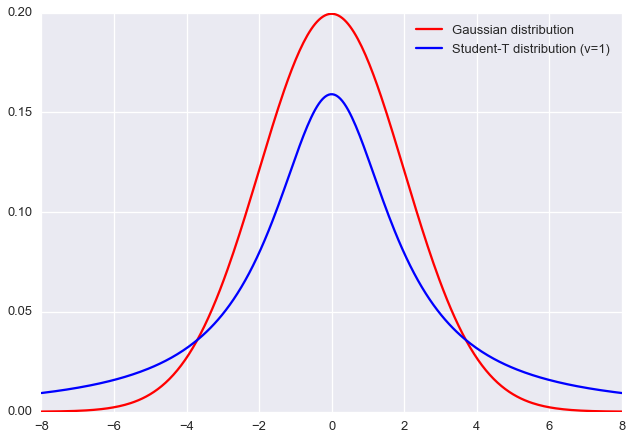

In [4]:
# Example of Gaussian versus Student-T
x_vals = np.linspace(-8, 8, 300)

# PDFs
norm = st.norm.pdf(x_vals, loc=0, scale=2)
stu_t = st.t.pdf(x_vals, df=1, loc=0, scale=2)

# Plot
plt.plot(x_vals, norm, 'r-', label='Gaussian distribution')
plt.plot(x_vals, stu_t, 'b-', label='Student-T distribution (v=1)')
plt.legend(loc='best')

In each test, we have two groups of data: regulated and unregulated. We assume that each group is drawn from a Student-T distribution and we're interested in estimating how different the parameters for these two distribution are. We will **assume that the two distributions have the same number of degrees of freedom, $\nu$**.

$$reg_i \sim T(\nu, \mu_1, \sigma_1^2)$$

$$unreg_i \sim T(\nu, \mu_2, \sigma_2^2)$$

The Bayesian approach requires us to specify priors for $\nu$, the $\mu_i$ and the $\sigma_i$. Following [Kruschke (2013)](http://www.indiana.edu/~kruschke/articles/Kruschke2013JEPG.pdf), we will set fairly broad, uninformative priors on these quantities:

$$\mu_1, \mu_2 \sim N \left( \overline {y_i}, 2 \overline {\sigma_i^2} \right)$$

$$\sigma_1, \sigma_2 \sim U (0, 20)$$

$$\nu \sim exp(30)$$

Described in words, the priors for $\mu_1$ and $\mu_2$ are Gaussian with the means equal to the overall mean of the pooled data and a variance that is twice the variance of the pooled data. The prior variances for the Student-T distributions are assumed to be uniform on the interval between 0 and 20 (although this will need adjusting for some datasets - see later), and the prior for $\nu$ is an exponential distribution with mean 30. This latter choice is made because it allocates credibility fairly evenly over the range between "nearly normal" and "heavy tailed". The diagram below (from [Kruschke, 2013](http://www.indiana.edu/~kruschke/articles/Kruschke2013JEPG.pdf)) illustrates this setup.

<img src="https://github.com/JamesSample/ECOREG/blob/master/Images/BEST_Kruschke_2013_Fig2.png?raw=true" alt="Metrics selected by PCA" width="800">

We are interested in the differences between the two groups, expressed as differences in the $\mu$ and $\sigma$ parameters for the two Student-T distributions. To keep this notebook tidy, I have added a function to the [ECOREG Python file](https://github.com/JamesSample/ECOREG/blob/master/ecoreg_code.py), which is imported below. This function uses Bayesian MCMC for parameter inference, with options for using the Metropolis method, Slice Sampling or the No U-Turn Sampler (NUTS) to explore the posterior distribution.

In [5]:
# Import custom functions
func_path = r'C:\Data\James_Work\Staff\Susi_S\ECOREG\Python\ECOREG\ecoreg_code.py'

ecoreg = imp.load_source('ecoreg_code', func_path)

### 5.1. Differences in PB in Germany

I'll start off by testing for differences in PB assemblages in Germany, something that was highlighted by the PCA. The first step is to get the German data for the three metrics of interest (overall PB richness, green algae richness and cyanobacteria abundance), split according to whether sites are regulated or unregulated.

In [6]:
# Columns to consider
pb_cols = ['pb_rich', 'green_rich', 'cyano_abund']

# Get PB data
df = pb_df[pb_cols]

# Join categorical variables to MZB data
df = df.join(site_df[['country', 'regulated']])

# Select country
df = df.query('country == "D"')

df.head()

,pb_rich,green_rich,cyano_abund,country,regulated
site,,,,,
107000582,8,3,37,D,1
107000628,11,3,11,D,0
107000671,2,1,0,D,0
107001160,4,2,1,D,0
107001168,6,4,64,D,1


#### 5.1.1. Overall PB richness

As this is the first example, I'll describe the full output in detail. Subsequent sections will omit the model diagnostics for brevity (but I have checked them all nevertheless).

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:05<00:00, 89.41it/s]


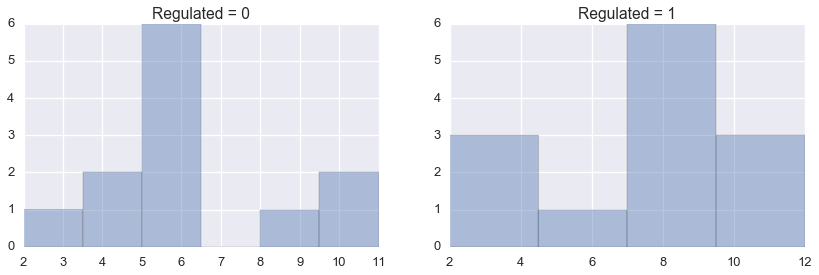

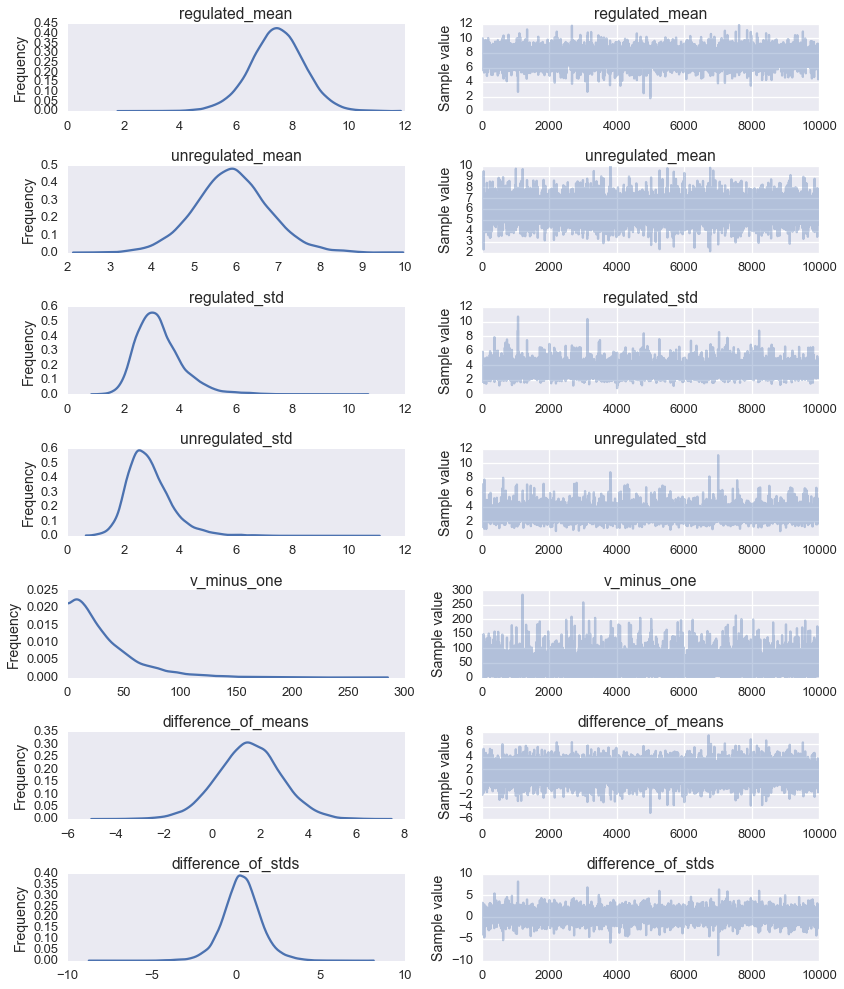

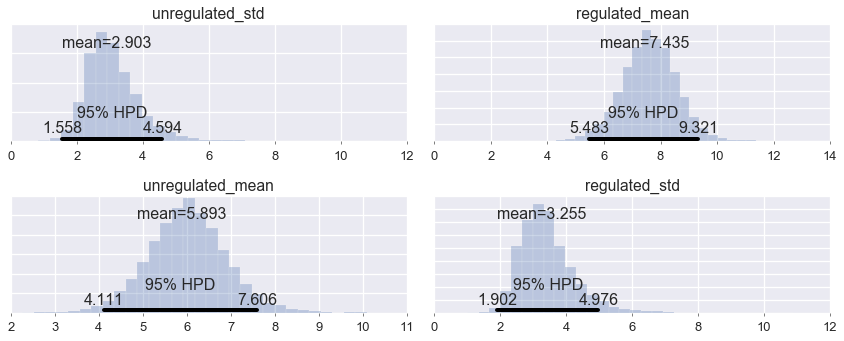

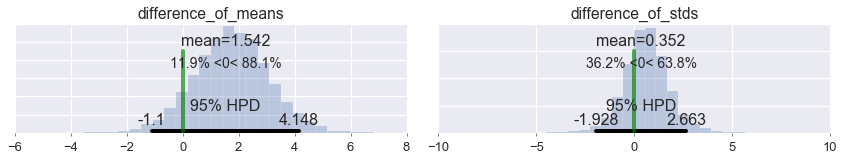

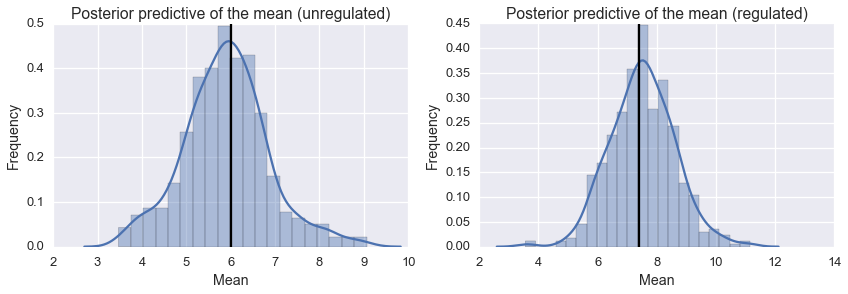

In [7]:
# Run MCMC
trace = ecoreg.bayesian_t(df, 'pb_rich', 
                          plot_trace=True, plot_ppc=True,
                          plot_vars=True, plot_diffs=True,
                          steps=10000, mcmc='slice')

The first row of the output simply shows histograms of the raw data, which give a rough indication of whether the core assumption of a Student-T distribution is broadly appropriate.

The next set of plots show the MCMC traces for each parameter, which should be reasonably stable in the latter 1000 or so steps if the algorithm has converged correctly.

The next four plots show posterior distributions, parameter estimates and credible intervals for the four key model parameters: the two group means and two standard deviations. The next two plots show posterior distributions for the differences between the means and the standard deviations, including 95% credible intervals and an indication of the probability (i.e. degree of belief) that the differences are non-zero.

The final row shows a Posterior Predictive Check (PPC) for each group, which can be used to assess the quality of the model. The PPC uses the fitted model to simulate a large number of additional datasets, which in principle should have similar properties to the original data. By comparing the distribution of simulated means for each group (represented by the KDE-smoothed histograms) with the actual data mean (vertical black line), we can get an idea of how well the estimated model reproduces the data.

For the example of overall PB richness shown above, the data histograms (top row) don't look especially like a Student-T distribution, but the PPC (last row) shows that the model does a pretty good job of fitting the data nevertheless, and the MCMC chains (rows 2 to 8) all seem to have converged.

From a scientific perspective, the most interesting plot is the one entitled `difference_of_means`. This suggests that PB richness scores for regulated sites are on average 1.5 units higher than unregulated sites, with a 95% Bayesian credible interval spanning -1.2 to +4.0 units. The distribution also implies that there is approximately an 88% probability that regulated sites have greater PB species richness than unregulated sites i.e. it is quite likely, but not "significant" with 95% confidence.

#### 5.1.2. Green algae richness and cyanobacteria abundance

The plots for green algae richness are not very interesting, but the results for cyanobacterial abundance are worth looking at in more detail. Note that in the code below I've increased the upper limit of the uniform priors for the $\sigma_i$, as it was obvious from the MCMC traces that the initial default value of 20 was in sufficient.

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:05<00:00, 90.40it/s]


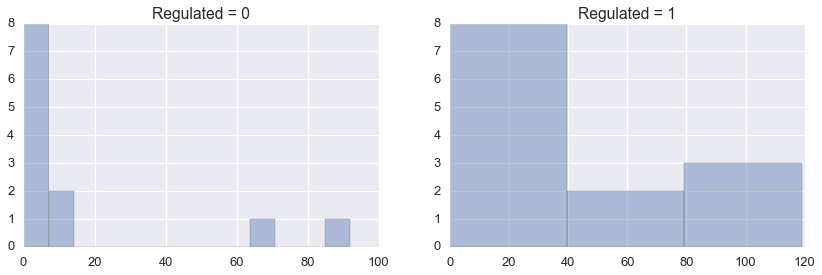

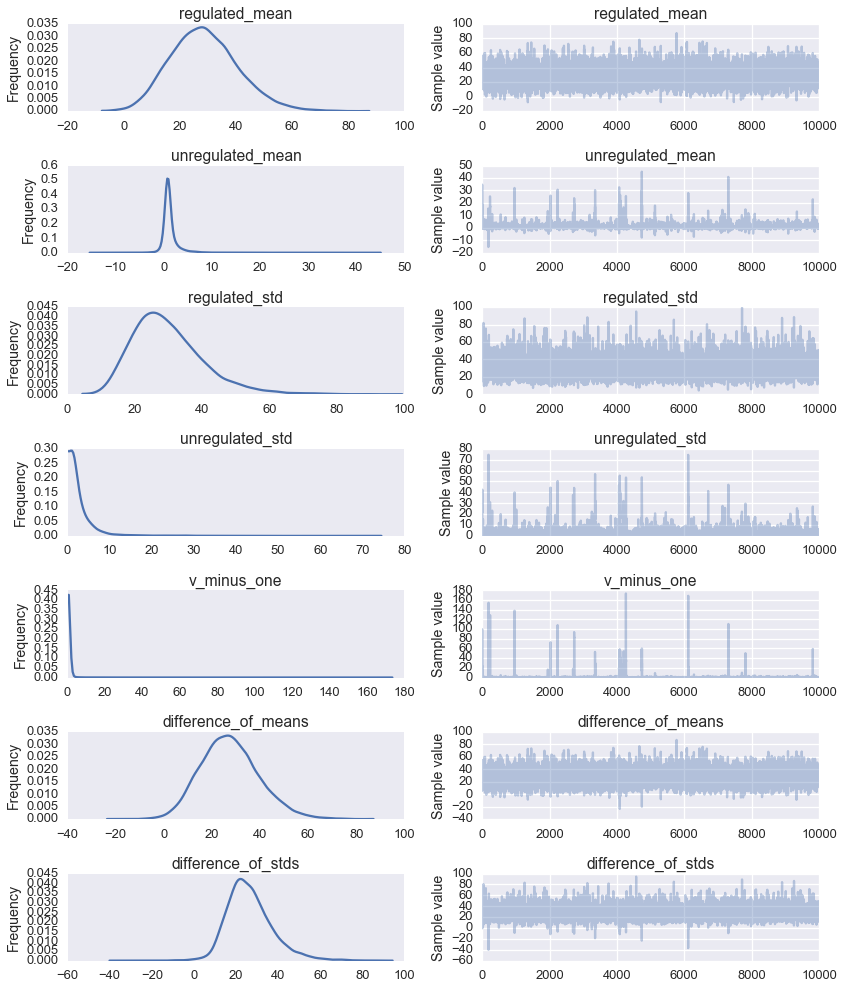

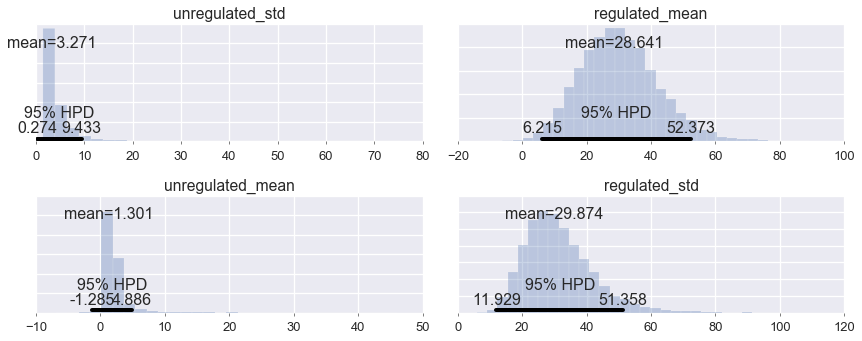

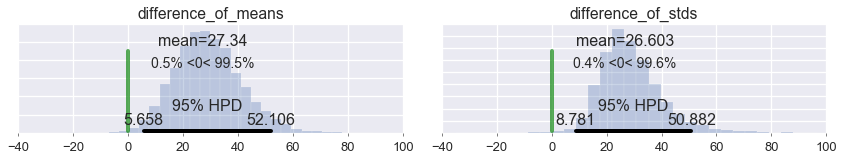

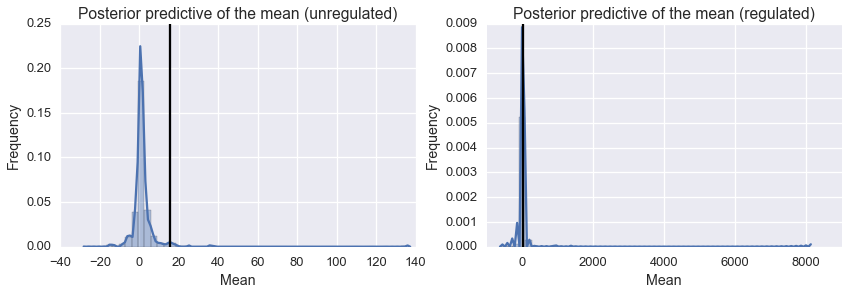

In [8]:
# Run MCMC
trace = ecoreg.bayesian_t(df, 'cyano_abund', 
                          plot_trace=True, plot_ppc=True,
                          plot_vars=True, plot_diffs=True,
                          steps=10000, mcmc='slice', 
                          unif_u=100)

Looking at the plot entitled `difference_in_means`, there are clearly significant differences in cyanobacteria abundance between regulated and unregulated sites. The mean difference in abundance is 27 (with a 95% credible interval from 4.8 to 53), and there is more than 99% probability that the two group means are distinct. However, the PPC (last row of plots) for the unregulated sites is worrying, because the model is unable to simulate the observed mean for this group effectively. The reason for this is clear from the very first plot: the raw data histogram is strongly right-skewed, and can therefore not be reasonably approximated by a Student-T distribution. We could try transforming the data and refitting, but interpretation then becomes more difficult. Given the results already obtained above for overall PB richness, I don't think there's much point - we can just use PB richness instead.

#### 5.1.3. PB in Norway

The PCA did not suggest differences in PB assemblages between regulated and unregulated sites in Norway. However, given the results above for Germany, it seems at least worth checking here. To save space I have not included the plots below, but the output suggests **no significant differences PB richness**, but an 85% chance that **regulated sites have greater overall abundance (by, on average, about 62 units)**.
 
### 5.2. Differences in MZB in Germany

The next test suggested by the PCA was to see whether regulated sites in Germany have different MZB abundances and numbers of taxa & genera.

In [9]:
# Columns to consider
mzb_cols = ['n_taxa', 'n_genera', 'abund']

# Get PB data
df = mzb_df[mzb_cols]

# Join categorical variables to MZB data
df = df.join(site_df[['country', 'regulated']])

# Select country
df = df.query('country == "D"')

df.head()

,n_taxa,n_genera,abund,country,regulated
site,,,,,
107000582,59,44,2224.467,D,1
107000628,71,59,1982.400,D,0
107000671,34,28,480.960,D,0
107001160,45,38,1578.400,D,0
107001168,43,33,330.400,D,1


#### 5.2.1. Number of taxa and genera

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 446.69it/s]


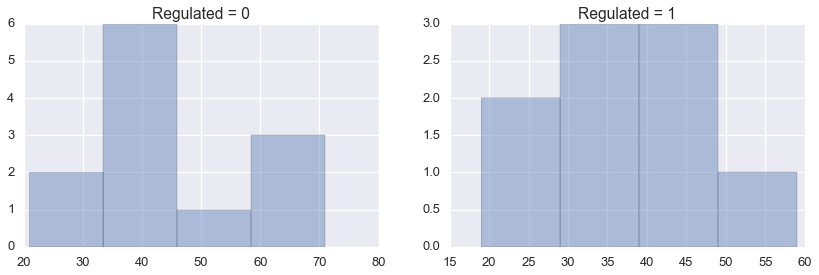

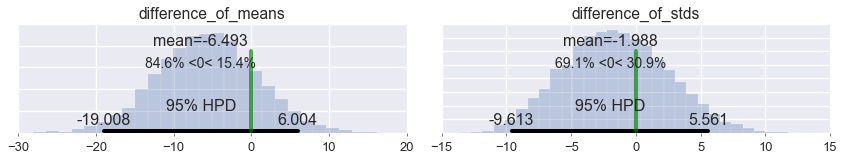

In [10]:
# Run MCMC
trace = ecoreg.bayesian_t(df, 'n_taxa', 
                          plot_trace=False, plot_ppc=False,
                          plot_vars=False, plot_diffs=True, 
                          steps=10000, mcmc='slice')

The model provides a reasonable fit to the data. On average, regulated sites in Germany has 6.4 fewer taxa than unregulated rivers, and there is roughly an 85% probability that the means of the two groups are different.

Unsurprisingly, the results for number of genera are virtually identical: regulated sites have on average 5.3 fewer genera and there is 86% confidence that the group means are different. I haven't included the plots here for the sake of brevity.

#### 5.2.2. Abundance

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 448.55it/s]


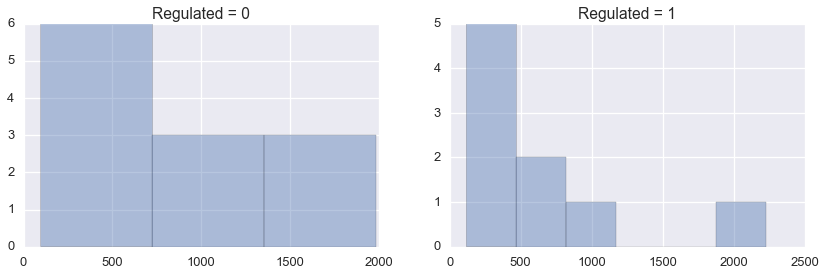

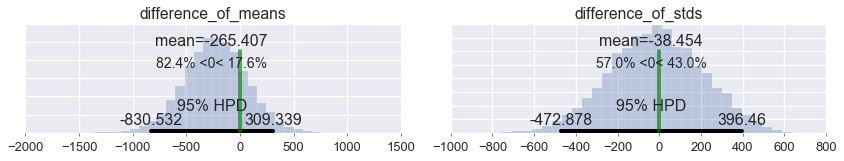

In [11]:
# Run MCMC
trace = ecoreg.bayesian_t(df, 'abund', 
                          plot_trace=False, plot_ppc=False,
                          plot_vars=False, plot_diffs=True,
                          steps=10000, mcmc='slice',
                          unif_u=1000)

Abundance scores in Germany for regulated sites are on average 267 units lower than for unregulated sites. There is 83% confidence that the group means are different.

### 5.3. Differences in MZB in Norway

The PCA highlighted four possible patterns to test for MZB in Norway:

 1. Do regulated sites have higher MZB abundance and a greater number of taxa and genera than unregulated sites? <br><br>
 
 2. Do regulated sites have a greater proportion of sessile species and active filter feeders? <br><br>
 
 3. Do regulated sites have a lower proportion of swimmers and divers? <br><br>
 
 4. Do regulated sites have lower scores on the German saprobic index?
 
Note that item (1) on this list is the exact opposite of the pattern in Germany, which is odd.

In [12]:
# Columns to consider
mzb_cols = ['n_taxa', 'n_genera', 'abund', 'sessil', 'acti_filt_feed', 
            'swim_div', 'ger_sap_idx']

# Get PB data
df = mzb_df[mzb_cols]

# Join categorical variables to MZB data
df = df.join(site_df[['country', 'regulated']])

# Select country
df = df.query('country == "N"')

df.head()

,n_taxa,n_genera,abund,sessil,acti_filt_feed,swim_div,ger_sap_idx,country,regulated
site,,,,,,,,,
S2.129,18,17,954.0,0.136,0.021,36.069,1.526,N,1
S2.267,32,30,1351.0,2.694,1.021,25.973,1.524,N,0
S2.268,17,16,562.0,16.690,7.936,26.157,1.644,N,0
S2.303,16,14,358.0,1.257,0.335,45.503,1.558,N,0
S2.32,37,32,2437.0,10.025,5.425,13.291,1.432,N,0


#### 5.3.1. Number of taxa and genera

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 437.20it/s]


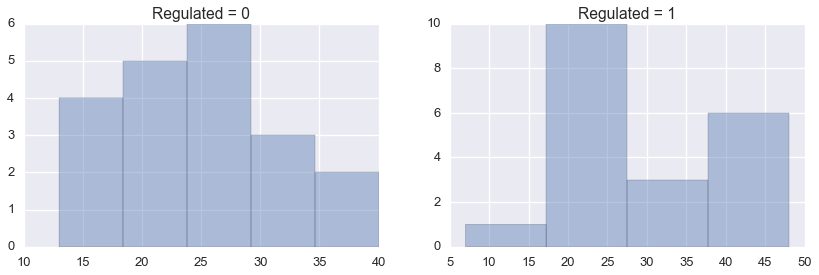

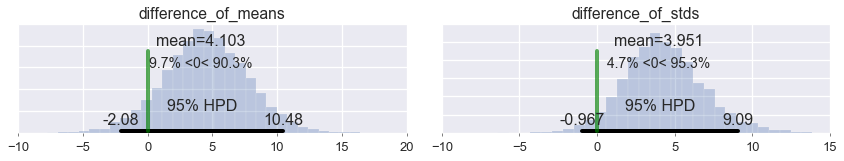

In [13]:
# Run MCMC
trace = ecoreg.bayesian_t(df, 'n_taxa', 
                          plot_trace=False, plot_ppc=False,
                          plot_vars=False, plot_diffs=True,
                          steps=10000, mcmc='slice')

The results for number of taxa and genera are essentially the same, so only one set of plots is shown above. There is roughly a 90% probability that regulated sites in Norway have *greater numbers* of taxa and genera than unregulated ones. The effect size is small, though: on average regulated sites have 4 more taxa and 3 more genera.

This implies the effect of regulation on MZB diversity in Norway is rather different (opposite?) to that in Germany, but the effect size may be negligible.

#### 5.3.2. Abundance

As shown in the plots below, the Norwegian abundance data for regulated sites is strongly right-skewed - there is a single site with an unusually high abundance (> 7000). This point is enough of an outlier that it causes problems for the model: the PPC indicates that the model is not able to recreate data with this pattern. To fit the model effectively, I therefore need to remove the point.

100%|████████████████████████████████████████████████████████████████████████████| 1001/1001 [00:00<00:00, 2566.67it/s]


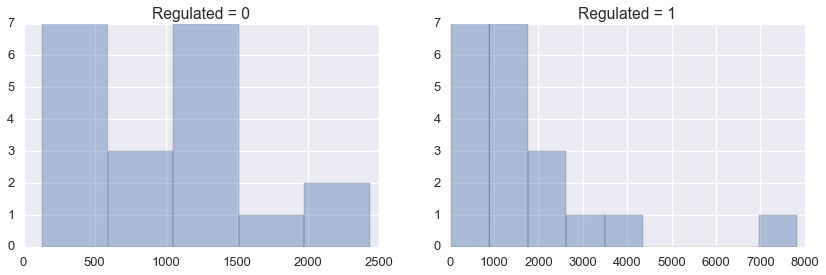

In [14]:
# Run MCMC
trace = ecoreg.bayesian_t(df, 'abund', 
                          plot_trace=False, plot_ppc=False,
                          plot_vars=False, plot_diffs=False,
                          steps=1001, mcmc='metropolis',
                          unif_u=5000)

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 448.17it/s]


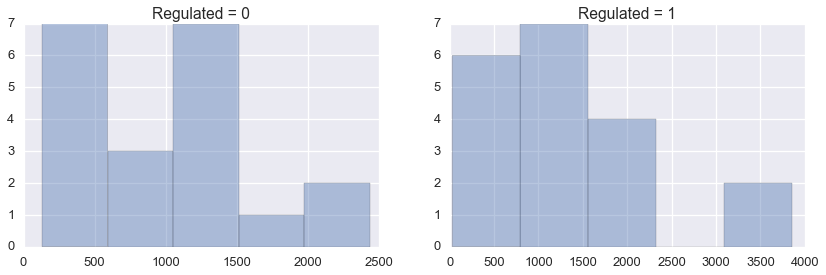

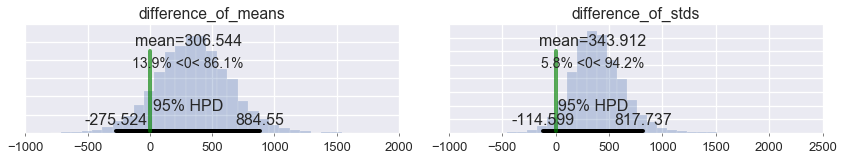

In [15]:
# Remove outlier
df2 = df.query('abund < 6000')

# Run MCMC
trace = ecoreg.bayesian_t(df2, 'abund', 
                          plot_trace=False, plot_ppc=False,
                          plot_vars=False, plot_diffs=True,
                          steps=10000, mcmc='slice',
                          unif_u=5000)

With the outlier removed, the model fits OK, and the output suggests that regulated sites in Norway have, on average, abundance scores that are around 300 units higher than unregulated sites. There is roughly an 85% probability that the two group means are different. Note that these estimates are likely to be conservative, because the outlier removed above indicates that some regulated sites may have much higher abundances. If this measurement is correct the difference would actually be greater than estimated here.

#### 5.3.3. Sessile species and active filter feeders

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 449.38it/s]


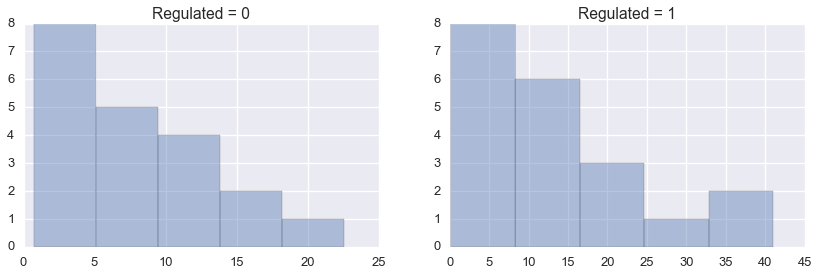

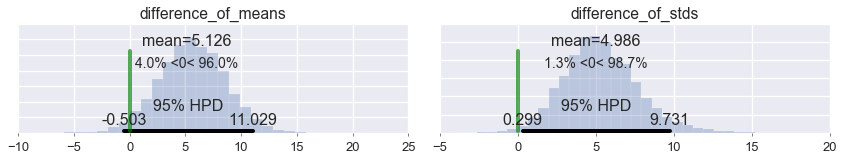

In [16]:
# Run MCMC
trace = ecoreg.bayesian_t(df, 'sessil', 
                          plot_trace=False, plot_ppc=False,
                          plot_vars=False, plot_diffs=True,
                          steps=10000, mcmc='slice')

In Norway, regulated sites have higher proportions of sessile species and active filter feeders. Unregulated sites typically have 7-8% sessile species and around 3% active filter feeders, whereas regulated sites have, on average, about 13% sessile species and 5.5% active filter feeders. Both these results are "significant" with 95% confidence.

#### 5.3.4. Swimmers and divers

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 445.43it/s]


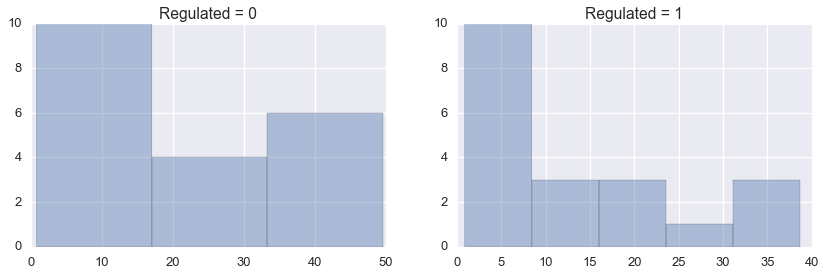

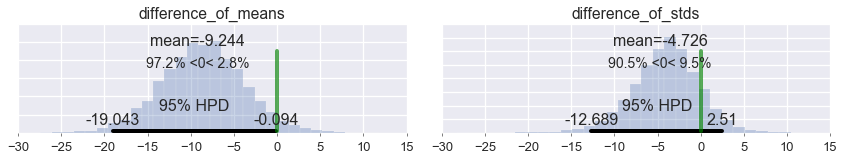

In [17]:
# Run MCMC
trace = ecoreg.bayesian_t(df, 'swim_div', 
                          plot_trace=False, plot_ppc=False,
                          plot_vars=False, plot_diffs=True,
                          steps=10000, mcmc='slice',
                          unif_u=50)

Regulated sites in Norway have significantly fewer swimmers and divers than found at unregulated sites (>97% probability). On average, scores for regulated sites are 9 units lower. 

#### 5.3.5. German saprobic index

There is no detectable difference here.

### 5.XX. Summary of tests for differences

#### 5.X.1. PB

##### Germany

 * There is an 88% probability that **regulated sites in Germany have higher overall PB richness than unregulated rivers**. <br><br>
 
 * However, the effect size is small: **regulated rivers have, on average, only 1.5 species more than unregulated ones**. <br><br>
 
 * There is 99% probability that regulated sites in Germany have higher cycanobacteria abundance than unregulated ones. However, the statistical model seems to be inappropriate, so this result cannot be trusted.
 
##### Norway

 * There is an 85% probability that **regulated sites in Germany have higher overall PB abundance than unregulated rivers**. <br><br>
 
 * On average, **regulated sites have a PB abundance score that is 62 units higher than unregulated ones**. 
 
#### 5.X.2. MZB

 * The effect of regulation on MZB abundance and diversity seems to act in opposite directions in Germany and Norway. Note, however, that the effect sizes are quite small and none of the relationships would be considered "significant" at the traditional (and arbitrary) 95% level.
 
##### Germany

 * There is roughly an 85% probability that **regulated sites in Germany have fewer MZB taxa & genera and overall lower abundance than unregulated sites**. <br><br>
 
 * On average, **regulated sites have 6.4 fewer taxa and 5.3 fewer genera and 267 fewer specimens than unregulated sites**.
 
##### Norway

 * There is roughly a 90% probability that **regulated sites in Norway have *greater numbers* of taxa and genera than unregulated ones**. <br><br>
 
 * On average **regulated sites have 4 more taxa and 3 more genera than unregulated sites**. <br><br>
 
 * There is a roughly 85% probability that regulated sites have higher MZB abundances than unregulated sites. The mean difference in abundance is about 300 units. Note, however, that the statistical model may not be appropriate in this case, and that an "outlier" had to be removed arbitrarily in order to fit it. <br><br>
 
 * There is more than 95% probability that **regulated sites have higher proportions of sessile species and active filter feeders, and lower proportions of swimmers and divers**. <br><br>
 
 * Unregulated sites typically have 7-8% sessile species, around 3% active filter feeders and 22% swimmers and divers; regulated sites have, on average, about 13% sessile species, 5.5% active filter feeders and 13% swimmers and divers.
 
 
### 5.YY. Interpretation of tests for differences

Although the PB assemblages in Germany and Norway are quite different, the overall effect of flow regulation seems to be broadly comparable in both locations: regulation results in slightly greater overall PB abundances (and also species richness in the case of Germany). These results are not statistically significant with 95% confidence, but the data nevertheless provide reasonably strong evidence to support this statement. This conclusion is not especially surprising, because regulated rivers tend to have more stable flow regimes (**test for this - not done yet**), with fewer extreme events (such as scouring or "drying out") than might be expected under a natural flow regime. This may allow benthic communities to develop more fully.

The patterns in the MZB data are more interesting, because the effects of flow regulation on overall MZB abundance and diversity seem to act in opposite directions in Germany compared to in Norway. German regulated rivers tend to have lower numbers of MZB taxa and genera and generally lower abundances overall, whereas in Norway the effect of regulation is of approximately the same magnitude, but in the opposite direction. As with PB, these differences are not "significant" at the 95% level, but the data nevertheless give substantial support to this statement. In addition, regulated sites in Norway have a significantly larger proportion of sessile species and active filter feeders, and a lower proportion of swimmers and divers, than at unregulated sites (both these results have > 95 % credibility). Based on my [previous exploratory analysis](http://nbviewer.jupyter.org/github/JamesSample/ECOREG/blob/master/ecoreg_prelim_analysis.ipynb), it is also the case that sites in Norway have a generally greater proportion of active filter feeders than sites in Germany.

I know essentially nothing about ecology, and I don't really even know what kinds of animals are classified as "sessile" or "active filter feeders". Presumably we're talking about bivalves like the Freshwater Pearl Mussel? Either way, I suspect sessile, active filter feeders will be particularly sensitive to water quality, which is perhaps why there are fewer of them in Germany (where the water quality is worse) than in Norway. If this is correct, it may explain the patterns in the MZB data. Regulated rivers are expected to have more stable flow regimes (see above), which would favour sessile MZB species in exactly the same way as PB species i.e. fewer drying and scouring events. However, perhaps in Germany the water quality is sufficiently poor that active filter feeders can't exploit this opportunity, whereas in Norway the combination stable flow conditions and generally good water quality is ideal for active filter feeders to flourish? This might be why regulation seems to favour overall MZB abundance and diversity in Norway, but not in Germany: in Norway the species pool includes organisms that can take advantage of the regulated regime, whereas in Germany it does not? 

And what about swimmers and divers? There are plenty of them in both Germany and Norway, but regulation in Norway seems to have a negative effect on them, but in Germany it doesn't (if anything, regulated sites in Germany have *more* swimmers and divers, although those results aren't shown here).

Sadly, I suspect this is all very well-understood basic ecology, and probably not interesting to professional ecologists (I think it's fun though).

**Note:** Overall, I'm wary of interpreting these results too much, as the data are limited (< 25 sites in Germany and 40 in Norway) and only a few of the tests produce results that are genuinely significant. Use with caution!